# Imports

In [38]:
import sys
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance, plot_partial_dependence

from scipy.cluster import hierarchy as hc
from scipy.stats import spearmanr

from pdpbox import pdp, info_plots

import plotly.express as px

In [2]:
ROOT = pathlib.Path().absolute().parent.parent
RAW_DATA_PATH = ROOT / 'data' / 'raw'
INTERIM_DATA_PATH = ROOT / 'data' / 'interim'
PROCESSED_DATA_PATH = ROOT / 'data' / 'processed'
DAYS_PRED = 28

# endure this project is in the path
sys.path.insert(0, ROOT.absolute().as_posix())
from src.data.process_data import reduce_memory_usage

# Load and build data pipeline

In [116]:
# we will work with just one department in one store
df = \
(pd
 .read_parquet(PROCESSED_DATA_PATH / 'train_validation' /'FOODS_3_CA_1.parquet')
 .pipe(reduce_memory_usage)
 .astype({c:'category' for c in ['wday','month','year']})
 .drop(columns=['id','dept_id','cat_id','store_id',
                'state_id','wday']))

# will use this column for cross validation
df['d'] = df['d'].str.split('_').str[1].astype(np.uint16)

# get rid of categories from aother parts of the dataset
for col, dtype in zip(df.columns, df.dtypes):
    if str(dtype) == 'category':
        df[col] = df[col].cat.remove_unused_categories()

# I want to undo get_dummies on event_names and event_types
# for simplicity only consider the first event if there is more than 1
event_name = \
(df
 .filter(like='event_name_')
 .assign(event_name_none=lambda df: ~df.any(axis=1))
 .stack()
 .reset_index()
 .rename(columns={'level_0':'index','level_1':'event_name',0:'is_event'})
 .query("""is_event == True""")
 .groupby('index', as_index=True)
 .first()
 .drop(columns=['is_event']))

event_type = \
(df
 .filter(like='event_type_')
 .assign(event_type_none=lambda df: ~df.any(axis=1))
 .stack()
 .reset_index()
 .rename(columns={'level_0':'index','level_1':'event_type',0:'is_event'})
 .query("""is_event == True""")
 .groupby('index', as_index=True)
 .first()
 .drop(columns=['is_event']))

# join in these 'un-dummied' features and drop the dummies
df = \
(df
 .join(event_type)
 .join(event_name)
 .filter(regex=r'^((?!event_name_).)*$')
 .filter(regex=r'^((?!event_type_).)*$')
#  .replace(
#      {'event_type':{'event_type_none':'none'},
#       'event_name':{'event_name_none':'none'}})
 .astype({c:'category' for c in ['event_type','event_name',
                                 'quarter','weekofyear',
                                 'day','dayofyear']}))

# separate out a test set
train = df[df.part=='train'].drop(columns=['part'])
train_labels = train.pop('demand')
train_dates = train[['d','date']].copy().reset_index(drop=True)

test = df[df.part=='validation'].drop(columns=['part'])
test_labels = test.pop('demand')
test_dates = test[['d','date']].copy().reset_index(drop=True)
del df, event_name, event_type

train['rolling_mean_t30'].agg(['min','max'])

min      0.000
max    231.875
Name: rolling_mean_t30, dtype: float64

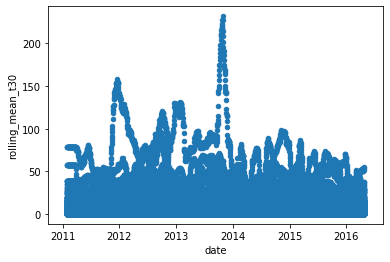

In [124]:
train[['date','rolling_mean_t30']].plot(kind='scatter', x='date', y='rolling_mean_t30')

So yes, the big spike we found iin pdp does exist

In [4]:
# select features
to_drop = ['day','weekofyear','dayofyear','item_id','quarter','d','date']

num_attribs = [col for col, dtype in zip(train.columns, train.dtypes)
               if ('float' in str(dtype) or 'int' in str(dtype))
               and col not in to_drop]

cat_attribs = [col for col, dtype in zip(train.columns, train.dtypes)
               if str(dtype)=='category'
               and col not in to_drop]

# define pipelines
num_pipeline = Pipeline([
    ('std_scalar', StandardScaler())])

cat_pipeline = Pipeline([
    ('one_hot_enc', OneHotEncoder())])

# combine pipelines
data_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
    ('drop', 'drop', to_drop)],
    remainder='passthrough')

train_prepared = data_pipeline.fit_transform(train, train_labels)
test_prepared = data_pipeline.transform(test)

columns = train.columns
del train, test

# Cross Validation

In [5]:
class CustomTimeSeriesSplitter:
    # want to use as much of the data as possible.
    # so the first fold will start on day 0 and last fold end day n
    # if fold length * n_folds < total lenght of data
    # just use most recent data without overlap ie:
    # first fold ends where second fold begins
    
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        # days from earliest date
        days = (X[self.day_col] - X[self.day_col].min())
        duration = days.max()
        train_test_days = self.train_days + self.test_days

        # if one fold use the most recent data
        if self.n_splits == 1:
            train_start = duration - train_test_days
            train_end = train_start + self.train_days

            train_mask = (days >= train_start) & (days < train_end)
            test_mask = days >= train_end

            yield days[train_mask].index.values, days[test_mask].index.values

        # if all the folds don't cover the full time period
        # just use the most recvent data without overlap
        elif duration > train_test_days * self.n_splits:
            
            for idx in range(self.n_splits):
                train_start = duration - train_test_days * (idx+1)
                train_end = train_start + self.train_days
                test_end = train_end + self.test_days
                
                train_mask = (days > train_start) & (days <= train_end)
                test_mask = (days > train_end) & (days <= test_end)
                
                yield days[train_mask].index.values, days[test_mask].index.values
             
        # otherwise spread the folds equally over the full time period
        else:
            split_starts = np.linspace(start=0,
                                       stop=duration-train_test_days,
                                       num=self.n_splits)
           
            for train_start in split_starts:
                train_end = train_start + self.train_days
                test_end = train_end + self.test_days
                
                train_mask = (days > train_start) & (days <= train_end)
                test_mask = (days > train_end) & (days <= test_end)
                
                yield days[train_mask].index.values, days[test_mask].index.values
                
                
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"])

        display(df)
        
def plot_cv_indices(cv, X, dt_col, lw=10):
    """"This is very slow to plot"""
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2)

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [6]:
day_col = "d"
dt_col = "date"
DAYS_PRED = 28

cv_params = {
    "n_splits": 5,
    "train_days": 365 * 2,
    "test_days": DAYS_PRED,
    "day_col": day_col}

cv = CustomTimeSeriesSplitter(**cv_params)
# show_cv_days(cv, train_dates, dt_col, day_col)
# plot_cv_indices(cv, train_dates, dt_col)

# Grid Search models and hyperparameters

In [20]:
class EstimatorSelectionHelper:
    """http://www.davidsbatista.net/blog/2018/02/23/model_optimization/"""

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    # for this project I need a custom CV 
    def fit(self, X, y, cv, cv_data, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True, cv=cv.split(cv_data))
            gs.fit(X,y)
            if verbose:
                print(params)
                print('Best Score:', np.sqrt(-gs.best_score_))
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score', ascending=False):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=ascending)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
models = {
#     'ExtraTreesRegressor': ExtraTreesRegressor(),
#     'RandomForestRegressor': RandomForestRegressor(),
#     'AdaBoostRegressor': AdaBoostRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
#     'SVR': SVR()
}

params = {
#     'ExtraTreesRegressor': { 'n_estimators': [16, 32] },
#     'RandomForestRegressor': { 'n_estimators': [16, 32] },
#     'AdaBoostRegressor':  { 'n_estimators': [16, 32] },
    'GradientBoostingRegressor': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
#     'SVR': [
#         {'kernel': ['linear'], 'C': [1, 10]},
#         {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},]
}

helper = EstimatorSelectionHelper(models, params)
helper.fit(train_prepared, train_labels, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, cv_data=train_dates)
helper.score_summary(sort_by='mean_score', ascending=True)

Running GridSearchCV for ExtraTreesRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.7min finished


{'n_estimators': [16, 32]}
Best Score: -18.906503258179498
Running GridSearchCV for RandomForestRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.8min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.9min finished


{'n_estimators': [16, 32]}
Best Score: -19.2228209640774
Running GridSearchCV for AdaBoostRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


{'n_estimators': [16, 32]}
Best Score: -28.32658694707306
Running GridSearchCV for GradientBoostingRegressor.
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  4.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min finished


{'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]}
Best Score: -19.742047581555596
Running GridSearchCV for SVR.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


<code>
Running GridSearchCV for ExtraTreesRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  8.0min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.7min finished
{'n_estimators': [16, 32]}
Best Score: -18.906503258179498
Running GridSearchCV for RandomForestRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  7.8min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.9min finished
{'n_estimators': [16, 32]}
Best Score: -19.2228209640774
Running GridSearchCV for AdaBoostRegressor.
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished
{'n_estimators': [16, 32]}
Best Score: -28.32658694707306
Running GridSearchCV for GradientBoostingRegressor.
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  4.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min finished
{'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]}
Best Score: -19.742047581555596
Running GridSearchCV for SVR.
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.</code>

GradientBoostingRegressor had comparable accuracy whilke training 4 times quicker than the other models

# Feature importances & model tuning

## Feature importances

In [24]:
# 1912 days
total_duration = train_dates.date.agg(['min','max']).diff().loc['max'].days

cv_params_tuning = {
    "n_splits": 1,
    "train_days": total_duration-28,
    "test_days": 28,
    "day_col": day_col}

cv_tuning = CustomTimeSeriesSplitter(**cv_params_tuning)

# we choose the gradient boosting estimator
model = GradientBoostingRegressor(n_estimators=32, learning_rate=0.8)

# get cross validated score
cv_scores = cross_val_score(
    model, train_prepared, train_labels,
    scoring='neg_mean_squared_error',
    cv=cv_tuning.split(train_dates),
    n_jobs=-1)

print('Mean ', np.mean(np.sqrt(-cv_scores)))

Mean  3.1080832139742505


3.11

In [7]:
# get all the feature names
attributes = num_attribs.copy()

# list of lists of categories in each cat_attrib
cat_categories = data_pipeline.named_transformers_['cat']
cat_categories = cat_categories['one_hot_enc'].categories_

# add each cat to the list if attributes
for cats, name in zip(cat_categories, cat_attribs):
    for cat in cats:
        attributes += [name+' - '+str(cat)]
        
# append the passthrough columns
attributes += [col for col in columns
               if col not in num_attribs+cat_attribs+to_drop]

In [26]:
# calculate the permutation importance
model.fit(train_prepared, train_labels)
print('model fitted')

result = permutation_importance(
    model, train_prepared, train_labels, n_repeats=3,
    random_state=42, n_jobs=-1,
    scoring='neg_root_mean_squared_error')

In [35]:
result.importances_mean

array([1.62164624e-01, 6.76196450e-01, 1.70632855e-01, 1.56528185e-02,
       5.94281006e-02, 2.62973661e+00, 1.52374325e-01, 8.33274122e-01,
       3.79577382e-01, 7.94272097e-01, 3.12671901e+00, 1.74441026e+00,
       5.79540156e-01, 1.73691270e+00, 1.49921413e-02, 0.00000000e+00,
       3.30258177e-03, 4.04526799e-01, 3.65415962e-03, 3.69601662e-02,
       2.96645531e-01, 4.03666517e-03, 5.37898909e-02, 1.96497268e-02,
       1.34797502e-02, 2.18048601e-02, 2.10833005e-03, 2.09937825e-02,
       1.82696442e-02, 0.00000000e+00, 0.00000000e+00, 3.20788115e-05,
       4.31644993e-03, 0.00000000e+00, 2.68189535e-03, 2.18846865e-03,
       2.07808185e-03, 0.00000000e+00, 7.79760352e-03, 8.90844291e-03,
       1.97863729e-03, 1.40240160e-02, 1.87568062e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00230873e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [39]:
# sort by importance keeping best 20
sorted_idx = result.importances_mean.argsort()[-20:]

# build dataframe 
to_plot = pd.DataFrame(
    result.importances_mean[sorted_idx].reshape(1,-1),
    columns=np.array(attributes)[sorted_idx]).melt()

# display(to_plot)
fig = px.scatter(to_plot, x='value', y='variable')

fig

In [8]:
# pick out the important features - for now the top 20

# top 20 features in order
# selected_features = np.array(attributes)[sorted_idx]
selected_features = [
    'weekday - Saturday', 'weekday - Friday', 'rolling_nonzero_sale_count_t90',
    'price_change_t365', 'rolling_std_t7', 'rolling_std_t60', 'sell_price_cent',
    'shift_t29', 'is_weekend', 'rolling_nonzero_sale_count_t180',
    'rolling_std_t180', 'rolling_nonzero_sale_count_t30', 'rolling_mean_t90',
    'shift_t28', 'rolling_mean_t7', 'rolling_std_t90', 'rolling_mean_t180',
    'rolling_mean_t60', 'rolling_std_t30', 'rolling_mean_t30']

# mask of features
feature_mask = [x in selected_features for x in attributes]

# features in order they appear in the rediuced dataseet
reduced_columns = [x for x in attributes if x in selected_features]

In [40]:
# retrain the model
model_reduced = GradientBoostingRegressor(n_estimators=32, learning_rate=0.8)

# get cross validated score
cv_scores_reduced = cross_val_score(
    model_reduced,
    train_prepared[:, feature_mask],
    train_labels,
    scoring='neg_mean_squared_error',
    cv=cv_tuning.split(train_dates),
    n_jobs=-1)

print('Mean ', np.mean(np.sqrt(-cv_scores_reduced)))

Mean  3.1341415652908875


3.13 - < 1% drop in performance for considerble speed improvement. From here on we will use this reduced training set.

In [9]:
train_reduced = train_prepared[:, feature_mask]

print(selected_features)

['weekday - Saturday', 'weekday - Friday', 'rolling_nonzero_sale_count_t90', 'price_change_t365', 'rolling_std_t7', 'rolling_std_t60', 'sell_price_cent', 'shift_t29', 'is_weekend', 'rolling_nonzero_sale_count_t180', 'rolling_std_t180', 'rolling_nonzero_sale_count_t30', 'rolling_mean_t90', 'shift_t28', 'rolling_mean_t7', 'rolling_std_t90', 'rolling_mean_t180', 'rolling_mean_t60', 'rolling_std_t30', 'rolling_mean_t30']


['weekday - Saturday' 'weekday - Friday' 'rolling_nonzero_sale_count_t90'
 'price_change_t365' 'rolling_std_t7' 'rolling_std_t60' 'sell_price_cent'
 'shift_t29' 'is_weekend' 'rolling_nonzero_sale_count_t180'
 'rolling_std_t180' 'rolling_nonzero_sale_count_t30' 'rolling_mean_t90'
 'shift_t28' 'rolling_mean_t7' 'rolling_std_t90' 'rolling_mean_t180'
 'rolling_mean_t60' 'rolling_std_t30' 'rolling_mean_t30']

## Dendogram & Tree Interpretor

corr calculated
corr condensed
z calculated
dendogram made


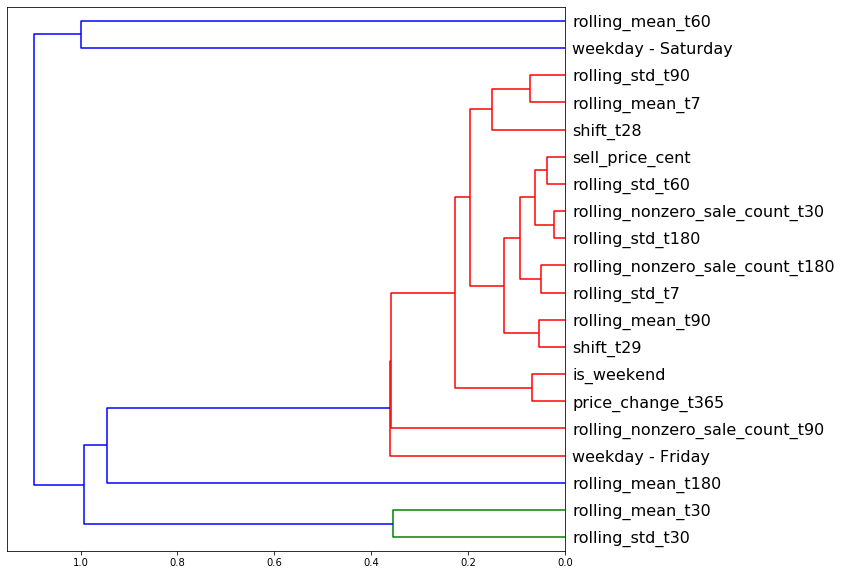

In [11]:
# correlation matrix
corr = np.round(spearmanr(train_reduced).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

# plot the correlation
fig = plt.figure(figsize=(10,10))

dendogram = hc.dendrogram(z, labels=selected_features, orientation='left', leaf_font_size=16)
plt.show()

The dendrogram shows which features are very similar, we could then try dropping one of the two similar features to see if the error changes. In this case none of the features are correlated enough to consider dropping. For comparison if we used the entire dataset:

corr calculated
corr condensed
z calculated
dendogram made


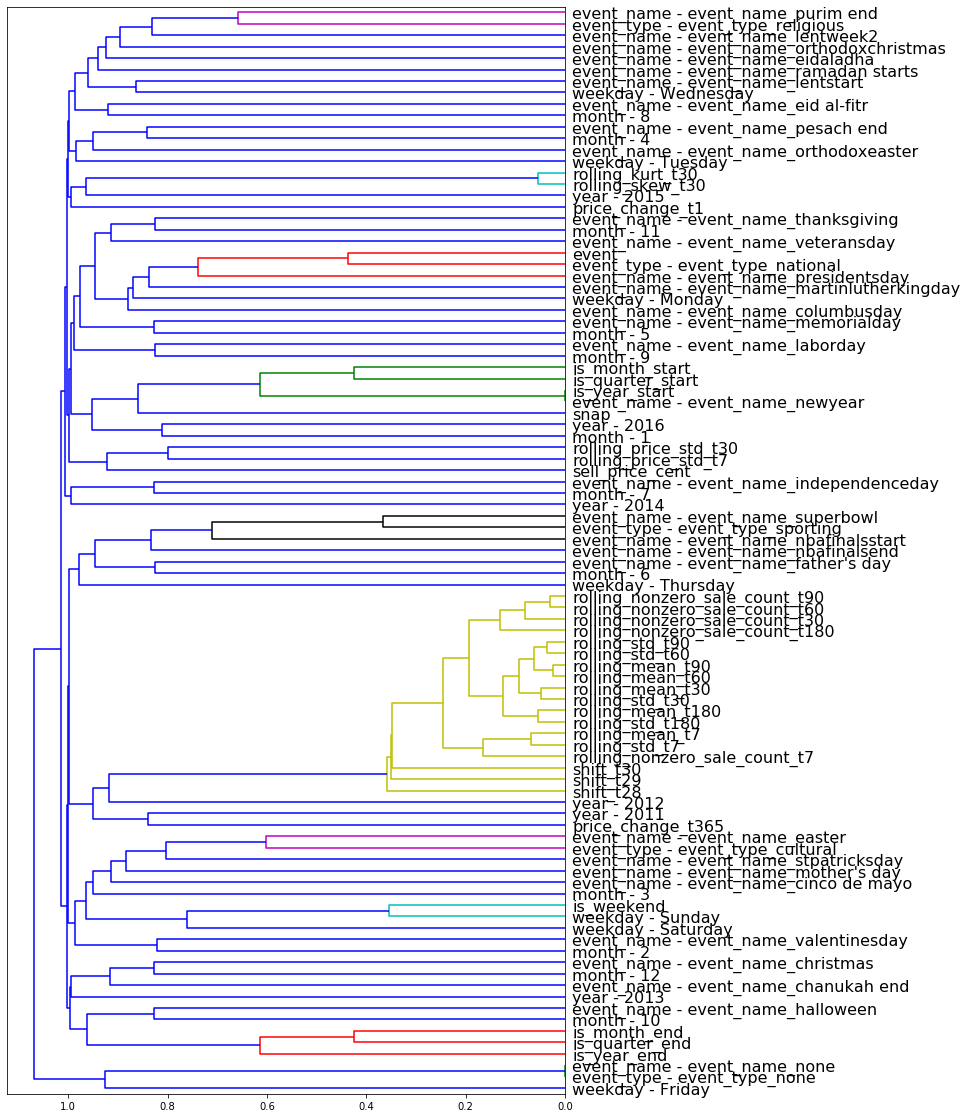

In [51]:
# correlation matrix
corr = np.round(spearmanr(train_prepared).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

# plot the correlation
fig = plt.figure(figsize=(10,20))

dendogram = hc.dendrogram(z, labels=attributes, orientation='left', leaf_font_size=16)
plt.show()

Here we see that "is_year_start" and "event name - event_name_newyear" are strongly correlated which is to be expected.

## Partial Dependence Plot

Visualize the impact of certain features towards model prediction for any supervised learning algorithm.

We know that rolling_mean_t30 is very important so let's look closer at it.

In [ ]:
# model wasn't fit when cross val was run
model_reduced = GradientBoostingRegressor(n_estimators=32, learning_rate=0.8)
model_reduced.fit(train_reduced, train_labels)

In [88]:
pdp_df = pd.DataFrame(train_reduced, columns=reduced_columns)
pdp_df = pdp_df.copy()#.sample(500, random_state=42).sort_index()
pdp_df = pdp_df.join(train_labels)
pdp_df

,sell_price_cent,shift_t28,shift_t29,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,rolling_mean_t7,rolling_mean_t30,...,rolling_mean_t90,rolling_mean_t180,rolling_nonzero_sale_count_t30,rolling_nonzero_sale_count_t90,rolling_nonzero_sale_count_t180,price_change_t365,weekday - Friday,weekday - Saturday,is_weekend,demand
0,-0.337365,-0.291840,-0.291787,-0.528099,-0.469531,-0.438556,-0.446924,-0.459602,-0.354004,-0.366607,...,-0.385892,-0.404854,0.359823,0.050961,-0.112945,-0.323777,0.0,1.0,1.0,1.0
1,-0.337365,-0.291840,-0.291787,-0.528099,-0.469531,-0.438556,-0.446924,-0.459602,-0.354004,-0.366607,...,-0.385892,-0.404854,0.359823,0.050961,-0.112945,-0.323777,0.0,0.0,1.0,1.0
2,-0.337365,-0.291840,-0.291787,-0.528099,-0.469531,-0.438556,-0.446924,-0.459602,-0.354004,-0.366607,...,-0.385892,-0.404854,0.359823,0.050961,-0.112945,-0.323777,0.0,0.0,0.0,1.0
3,-0.337365,-0.291840,-0.291787,-0.528099,-0.469531,-0.438556,-0.446924,-0.459602,-0.354004,-0.366607,...,-0.385892,-0.404854,0.359823,0.050961,-0.112945,-0.323777,0.0,0.0,0.0,1.0
4,-0.337365,-0.291840,-0.291787,-0.528099,-0.469531,-0.438556,-0.446924,-0.459602,-0.354004,-0.366607,...,-0.385892,-0.404854,0.359823,0.050961,-0.112945,-0.323777,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257133,-1.060685,-0.291840,0.255787,0.247976,0.281389,0.208040,0.111615,0.257070,0.202371,0.151249,...,0.042855,0.111964,1.198935,0.972076,0.963278,-0.323777,0.0,0.0,0.0,0.0
1257134,-1.060685,-0.018009,-0.291787,0.145575,0.283150,0.185861,0.104951,0.257070,0.246778,0.146138,...,0.048499,0.111282,1.198935,1.010456,0.963278,-0.323777,0.0,0.0,0.0,0.0
1257135,-1.060685,0.118906,-0.018000,0.148678,0.276694,0.181312,0.102174,0.256540,0.224270,0.156999,...,0.054142,0.112986,1.198935,1.010456,0.963278,-0.323777,1.0,0.0,0.0,0.0
1257136,-1.060685,0.392737,0.118893,0.148678,0.274346,0.175056,0.098842,0.254421,0.224270,0.178719,...,0.052151,0.118783,1.198935,1.010456,0.983974,-0.323777,0.0,1.0,1.0,0.0


### Binary Feature

#### target distribution through feature 'is_weekend'

,x,display_column,count,demand
0,0,is_weekend_0,896780,3.128281
1,1,is_weekend_1,360358,3.188742


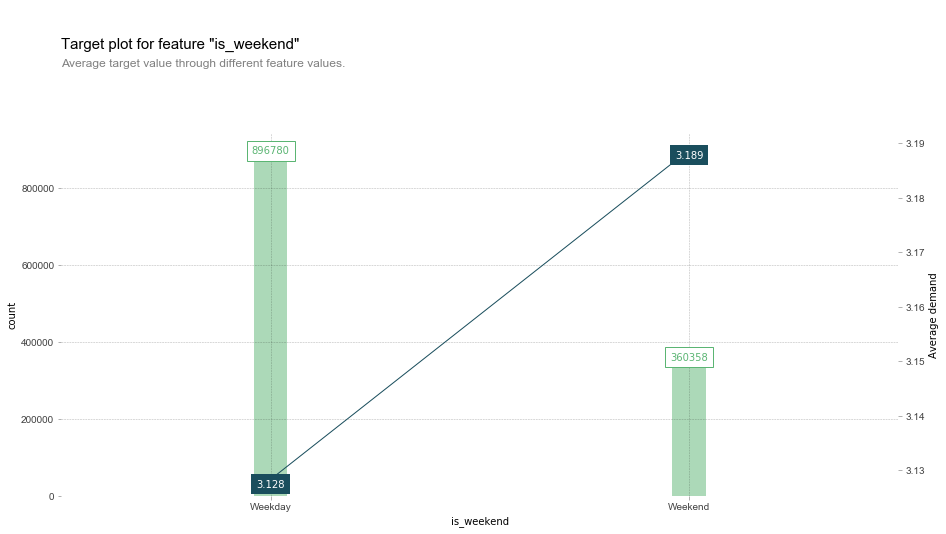

In [91]:
fig, axes, summary_df = \
info_plots.target_plot(
    df=pdp_df,
    feature='is_weekend',
    feature_name='is_weekend',
    target='demand')

_ = axes['bar_ax'].set_xticklabels(['Weekday', 'Weekend'])

display(summary_df)

#### check prediction distribution through feature 'is_weekend'

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,is_weekend_0,896780,0.667576,1.383107,2.691305
1,1,is_weekend_1,360358,1.057885,1.617452,3.985386


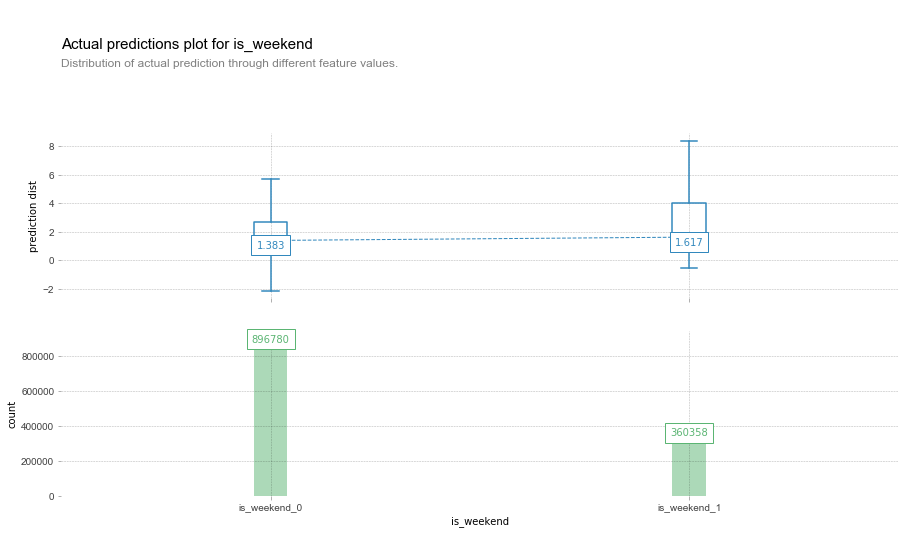

In [140]:
fig, axes, summary_df = \
info_plots.actual_plot(
    model=model_reduced,
    X=pdp_df.drop(columns=['demand']),
    feature='is_weekend',
    feature_name='is_weekend',
    predict_kwds={}
)

display(summary_df)

In [139]:
info_plots.actual_plot??


#### pdp for feature 'is_weekend'

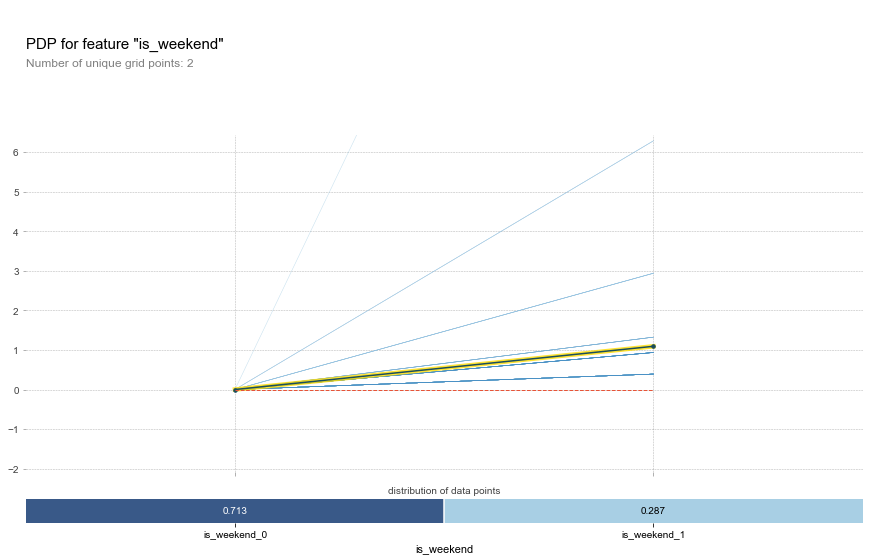

In [96]:
p = pdp.pdp_isolate(
    model=model_reduced,
    dataset=pdp_df,
    model_features=reduced_columns,
    feature='is_weekend')

fig, axes = \
pdp.pdp_plot(
    p,
    'is_weekend',
    plot_lines=True,
    frac_to_plot=100,
    plot_pts_dist=True)

### one-hot encoding feature

#### target distribution through feature 'weekday'

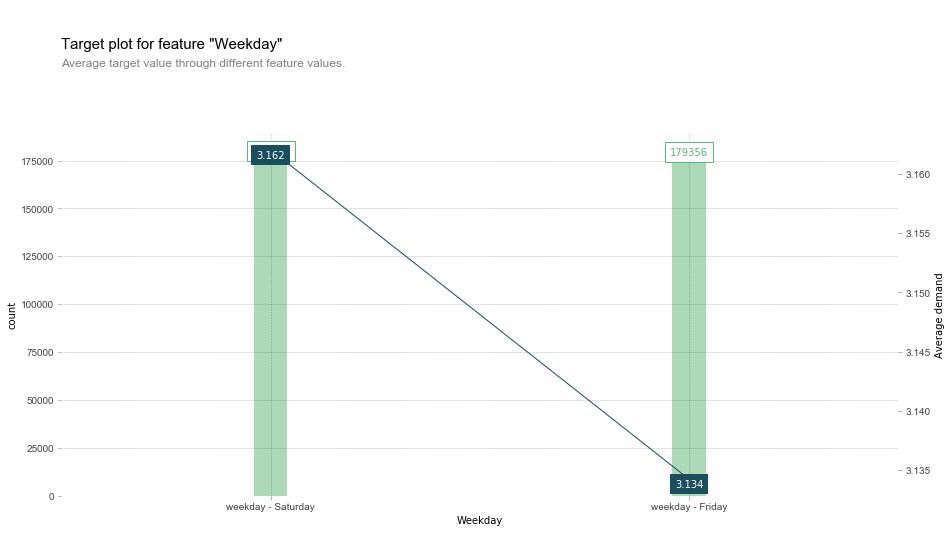

In [97]:
fig, axes, summary_df = \
info_plots.target_plot(
    df=pdp_df,
    feature=['weekday - Saturday', 'weekday - Friday'], 
    feature_name='Weekday',
    target='demand')

display(summary_df)

#### check prediction distribution through feature 'weekday'

,x,display_column,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,weekday - Saturday,180179,1.057885,1.617452,3.985386
1,1,weekday - Friday,179356,0.932582,1.492148,2.984306


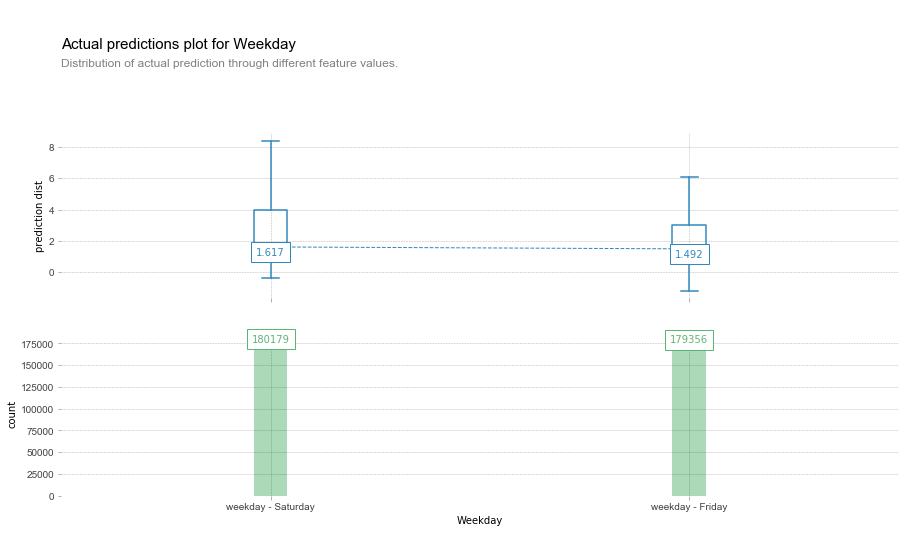

In [141]:
fig, axes, summary_df = \
info_plots.actual_plot(
    model=model_reduced,
    X=pdp_df.drop(columns=['demand']),
    feature=['weekday - Saturday', 'weekday - Friday'],
    feature_name='Weekday',
    predict_kwds={})

display(summary_df)

#### pdp for feature 'weekday'

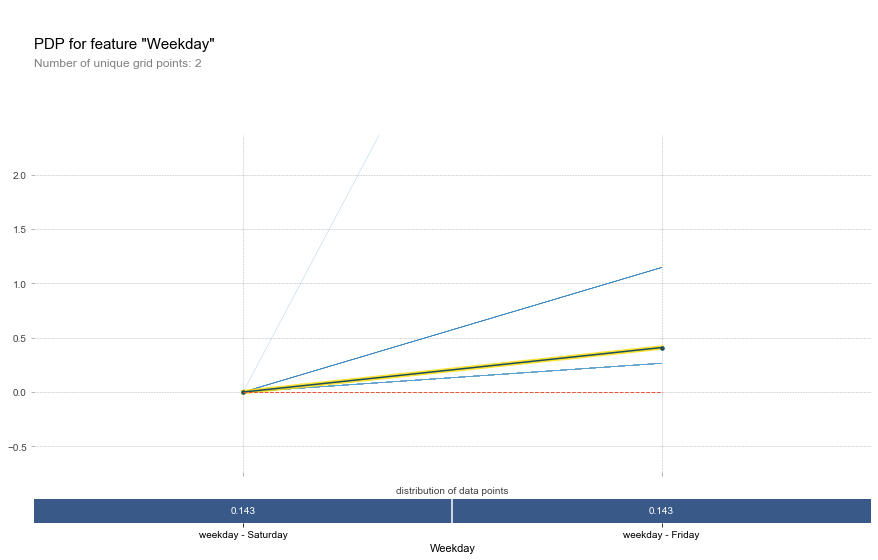

In [100]:
pdp_StoreType = \
pdp.pdp_isolate(
    model=model_reduced,
    dataset=pdp_df,
    model_features=reduced_columns, 
    feature=['weekday - Saturday', 'weekday - Friday'])

fig, axes = \
pdp.pdp_plot(
    pdp_StoreType,
    'Weekday',
    plot_lines=True,
    frac_to_plot=100,
    plot_pts_dist=True)

### Numeric feature

#### target distribution through feature 'rolling_mean_t30'

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,demand
0,0,"[-0.51, -0.5)",-0.513779,-0.502879,"[0, 11.11)",0.00,11.11,136080,3.496855
1,1,"[-0.5, -0.43)",-0.502879,-0.426578,"[11.11, 22.22)",11.11,22.22,134635,2.921604
2,2,"[-0.43, -0.37)",-0.426578,-0.372037,"[22.22, 33.33)",22.22,33.33,141200,3.213278
3,3,"[-0.37, -0.31)",-0.372037,-0.312067,"[33.33, 44.44)",33.33,44.44,142009,3.063600
4,4,"[-0.31, -0.24)",-0.312067,-0.241156,"[44.44, 55.56)",44.44,55.56,137126,3.035904
5,5,"[-0.24, -0.13)",-0.241156,-0.132075,"[55.56, 66.67)",55.56,66.67,142973,3.134157
6,6,"[-0.13, 0.07)",-0.132075,0.074908,"[66.67, 77.78)",66.67,77.78,143682,3.221272
7,7,"[0.07, 0.53)",0.074908,0.527523,"[77.78, 88.89)",77.78,88.89,139025,3.351839
8,8,"[0.53, 37.41]",0.527523,37.407524,"[88.89, 100]",88.89,100.00,140408,2.873049


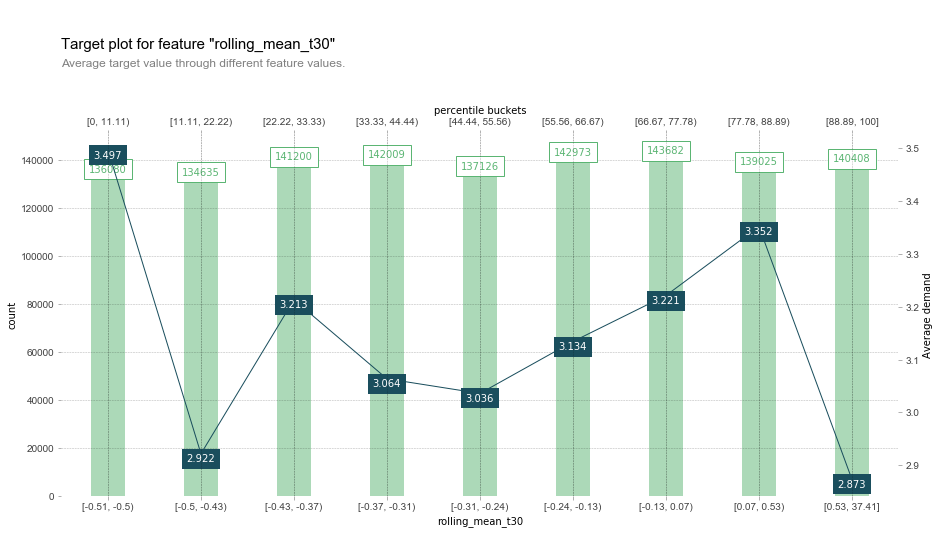

In [102]:
fig, axes, summary_df = \
info_plots.target_plot(
    df=pdp_df,
    feature='rolling_mean_t30', 
    feature_name='rolling_mean_t30',
    target='demand',
    show_percentile=True)

display(summary_df)

#### check prediction distribution through feature 'rolling_mean_t30'

,x,display_column,value_lower,value_upper,percentile_column,percentile_lower,percentile_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[-0.51, -0.5)",-0.513779,-0.502879,"[0, 11.11)",0.00,11.11,136080,0.226637,0.616946,1.057885
1,1,"[-0.5, -0.43)",-0.502879,-0.426578,"[11.11, 22.22)",11.11,22.22,134635,0.421188,0.616946,0.811497
2,2,"[-0.43, -0.37)",-0.426578,-0.372037,"[22.22, 33.33)",22.22,33.33,141200,0.421188,0.686193,0.980754
3,3,"[-0.37, -0.31)",-0.372037,-0.312067,"[33.33, 44.44)",33.33,44.44,142009,0.667576,1.057885,1.371063
4,4,"[-0.31, -0.24)",-0.312067,-0.241156,"[44.44, 55.56)",44.44,55.56,137126,1.140976,1.227143,1.617452
5,5,"[-0.24, -0.13)",-0.241156,-0.132075,"[55.56, 66.67)",55.56,66.67,142973,1.498992,1.829673,2.207679
6,6,"[-0.13, 0.07)",-0.132075,0.074908,"[66.67, 77.78)",66.67,77.78,143682,2.105771,2.496080,3.217561
7,7,"[0.07, 0.53)",0.074908,0.527523,"[77.78, 88.89)",77.78,88.89,139025,3.345351,4.149724,5.208142
8,8,"[0.53, 37.41]",0.527523,37.407524,"[88.89, 100]",88.89,100.00,140408,7.164600,10.183239,15.970991


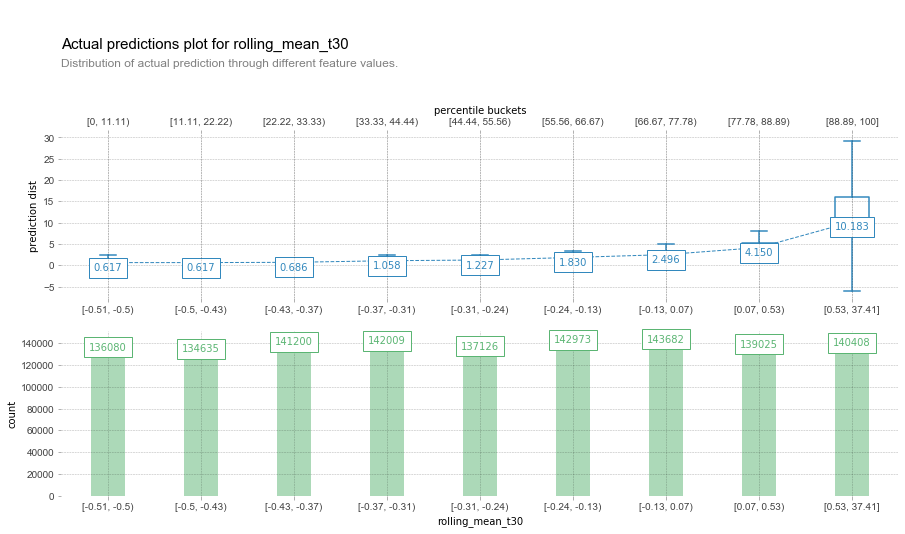

In [142]:
fig, axes, summary_df = \
info_plots.actual_plot(
    model=model_reduced,
    X=pdp_df.drop(columns=['demand']),
    feature='rolling_mean_t30', 
    feature_name='rolling_mean_t30',
    show_percentile=True,
    predict_kwds={})

display(summary_df)

#### pdp for feature 'rolling_mean_t30'

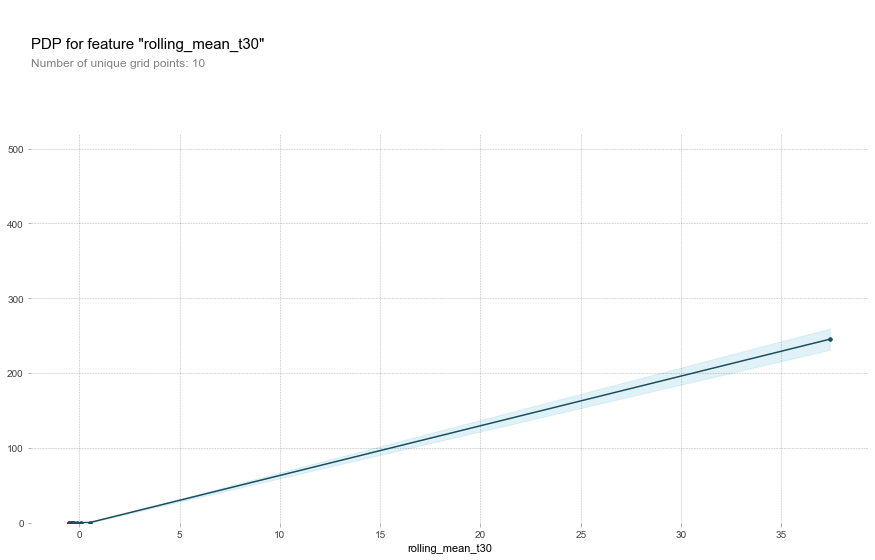

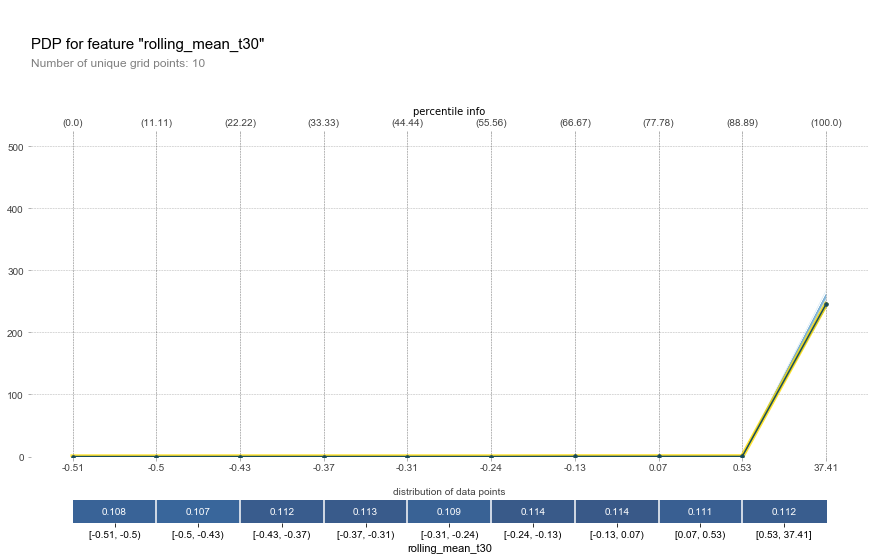

In [107]:
pdp_weekofyear = \
pdp.pdp_isolate(
    model=model_reduced,
    dataset=pdp_df,
    model_features=reduced_columns,
    feature= 'rolling_mean_t30')

fig, axes = pdp.pdp_plot(pdp_weekofyear, 'rolling_mean_t30')

fig, axes = pdp.pdp_plot(
    pdp_weekofyear,
    'rolling_mean_t30',
    plot_lines=True,
    frac_to_plot=100,
    x_quantile=True, 
    plot_pts_dist=True,
    show_percentile=True)

### Interaction between two variables

#### target distribution through feature combination of 'weekday' and 'rolling_mean_t30'

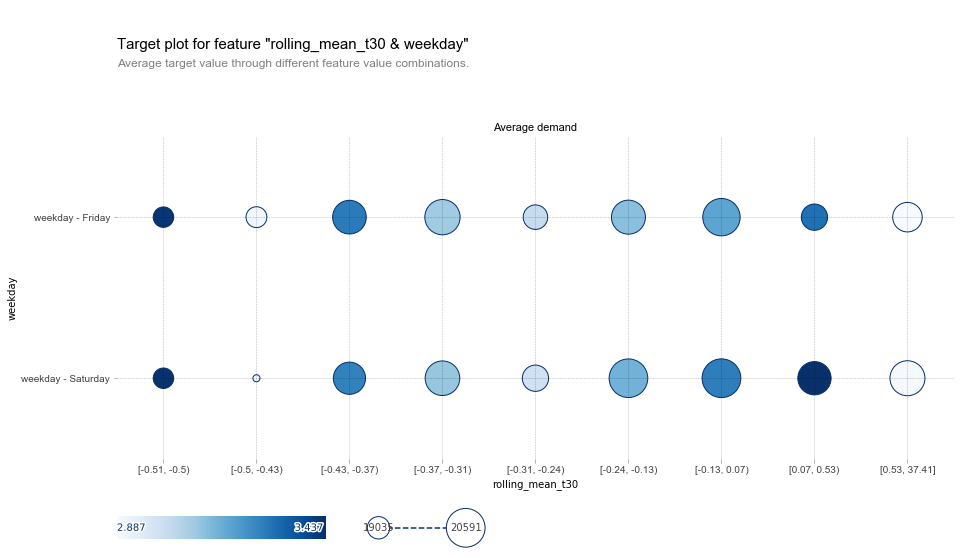

In [125]:
fig, axes, summary_df = \
info_plots.target_plot_interact(
    df=pdp_df,
    features=[
        'rolling_mean_t30',
        ['weekday - Saturday', 'weekday - Friday']], 
    feature_names=['rolling_mean_t30', 'weekday'],
    target='demand')

display(summary_df)

#### prediction distribution through feature combination of 'weekday' and 'rolling_mean_t30'

,x1,x2,display_column_1,display_column_2,value_lower_1,value_upper_1,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,0,"[-0.51, -0.5)",weekday - Saturday,-0.513779,-0.502879,19430,0.616946,0.777167,1.057885
1,0,1,"[-0.51, -0.5)",weekday - Friday,-0.513779,-0.502879,19429,0.491642,0.651864,0.932582
2,1,0,"[-0.5, -0.43)",weekday - Saturday,-0.502879,-0.426578,19035,0.616946,0.811497,1.057885
3,1,1,"[-0.5, -0.43)",weekday - Friday,-0.502879,-0.426578,19447,0.491642,0.686193,0.932582
4,2,0,"[-0.43, -0.37)",weekday - Saturday,-0.426578,-0.372037,20094,0.811497,0.971719,1.057885
5,2,1,"[-0.43, -0.37)",weekday - Friday,-0.426578,-0.372037,20197,0.686193,0.932582,0.932582
6,3,0,"[-0.37, -0.31)",weekday - Saturday,-0.372037,-0.312067,20265,1.057885,1.187307,1.617452
7,3,1,"[-0.37, -0.31)",weekday - Friday,-0.372037,-0.312067,20317,0.932582,1.092804,1.492148
8,4,0,"[-0.31, -0.24)",weekday - Saturday,-0.312067,-0.241156,19722,1.371063,1.617452,1.617452
9,4,1,"[-0.31, -0.24)",weekday - Friday,-0.312067,-0.241156,19625,1.245760,1.492148,1.492148


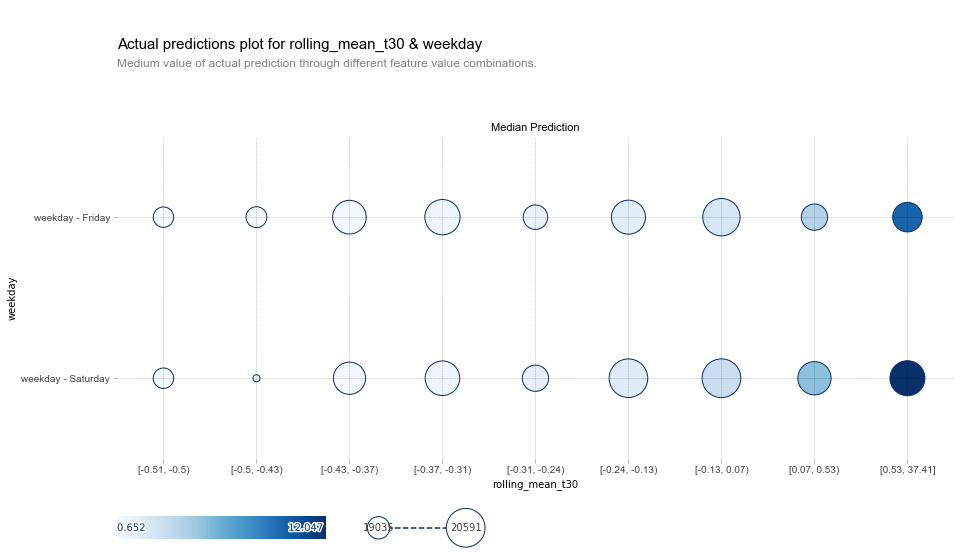

In [127]:
fig, axes, summary_df = \
info_plots.actual_plot_interact(
    model=model_reduced,
    X=pdp_df.drop(columns=['demand']), 
    features=[
        'rolling_mean_t30',
        ['weekday - Saturday', 'weekday - Friday']], 
    feature_names=['rolling_mean_t30', 'weekday'])

display(summary_df)

#### pdp for feature combination of 'weekday' and 'rolling_mean_t30'

In [133]:
inter_rf = \
pdp.pdp_interact(
    model=model_reduced,
    dataset=pdp_df,
    model_features=reduced_columns, 
    features=[
        'rolling_mean_t30',
        ['weekday - Saturday', 'weekday - Friday']])

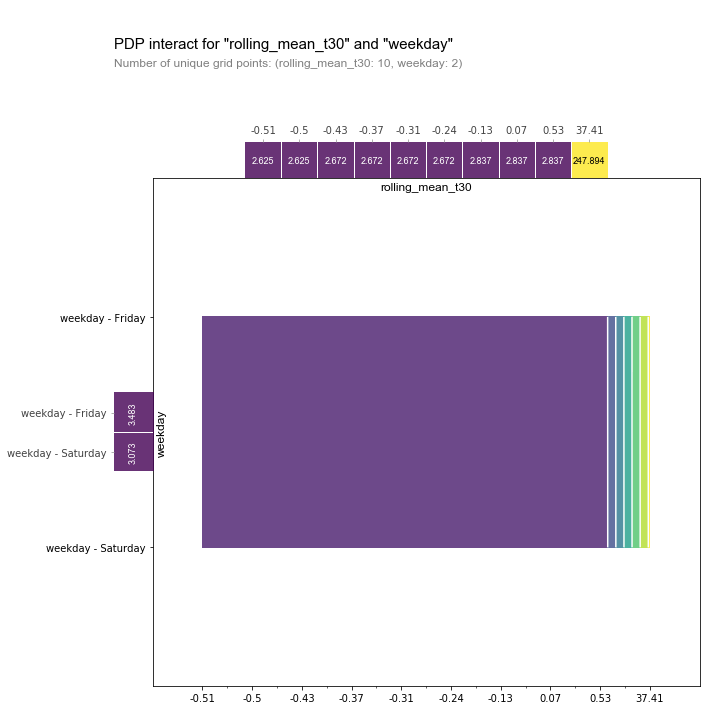

In [144]:
# there is an error in pdp due to a matplotlib update
try:
    fig, axes = \
    pdp.pdp_interact_plot(
        inter_rf,
        ['rolling_mean_t30', 'weekday'],
        x_quantile=True,
        plot_type='contour',
        plot_pdp=True)
except:
    pass

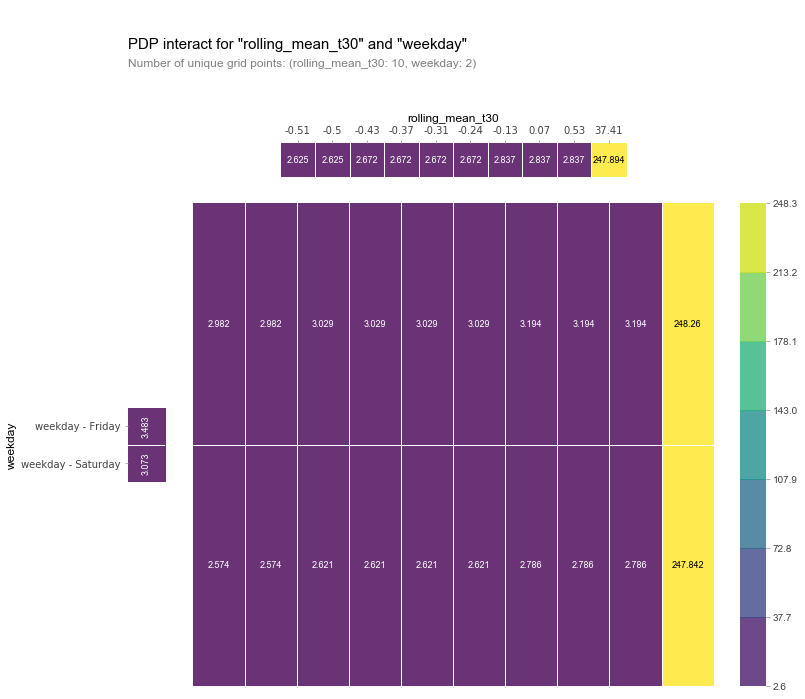

In [137]:
fig, axes = pdp.pdp_interact_plot(
    inter_rf,
    ['rolling_mean_t30', 'weekday'],
    x_quantile=True,
    plot_type='grid',
    plot_pdp=True)

redo with pdp as the plots are far better

## Tree Interpretor

In [ ]:
pdp.pdp_isolate()

# More complex models

## LightGBM

## XGBoost

## CatBoost

# Select Best Model and retrain on all data

# Make predictions and save model